In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=a4d837c007bf0cc60187c7a8b9294de91dfe507cb47631f752841dc4322eb8aa
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
import os
import time
import numpy as np
import pandas as pd
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas_ta as ta

In [4]:
def dataset_preprocessing(path):
    df = pd.read_csv(path).iloc[:,:-1]
    df_features = df.iloc[:,1:]
    # Features engineering
    df_features['ROC'] = ta.roc(df_features.close, length=15)
    df_features['%R'] = ta.willr(close = df_features.close, high = df_features.high, low = df_features.low, length=14)
    df_features['CCI'] = ta.cci(close = df_features.close, high = df_features.high, low = df_features.low, length=14, c=0.015)
    df_features['RSI'] = ta.rsi(close = df_features.close, high = df_features.high, low = df_features.low, length=14, scalar=100, drift=1)
    df_features['OBV'] = ta.obv(close = df_features.close, volume = df_features.volume)

    # Normalization
    df_array = df_features.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_array = scaler.fit_transform(df_array)
    normalized_df = pd.DataFrame(normalized_array, columns=df_features.columns)
    normalized_df.insert(0, "time", df["time"])
    normalized_df.dropna(inplace=True)

    normalized_df.to_csv("/content/drive/MyDrive/Thesis/preprocessed_fpt_stock.csv", index=False)

path = "/content/drive/MyDrive/Thesis/fpt_stock.csv"
dataset_preprocessing(path)

In [5]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f"Offset will be change from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        # Load the data
        self.df = pl.read_csv(file_path)
        if date_column is not None:
            self.df = self.df.drop(date_column)

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape = }')
        print(f'{self.y_train.shape = }')
        self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape = }')
        print(f'{self.y_val.shape = }')
        self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape = }')
        print(f'{self.y_test.shape = }')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns

        return np.array(features), np.array(labels)

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

In [6]:
import torch
import torch.nn as nn

class ModelManager(TimeSeriesDataLoader):
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn't exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images

class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')

    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_squared_error
        #from sklearn.metrics import mean_absolute_error

        # print(self.preprocessing(y).shape)
        # print(self.predict(self.preprocessing(x)).shape)
        return mean_squared_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

### Configs

In [8]:
input_size = 30
label_size = 1
offset = 1
train_size = 0.8
val_size = 0.1
num_epochs = 1_000
patience = 100
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = None
target_name = 'close'
date_column = 'time'
file_path = '/content/drive/MyDrive/Thesis/preprocessed_fpt_stock.csv'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

In [9]:
# features_type='S'
# sub_dir = 'uni2uni'
features_type='MS'
sub_dir = 'multi2multi'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2multi_loader = TimeSeriesDataLoader(file_path,
                                          input_size=input_size,
                                          label_size=label_size,
                                          offset=offset,
                                          train_size=train_size,
                                          val_size=val_size,
                                          target_name=target_name,
                                          features_type=features_type,
                                          date_column=date_column)

self.X_train.shape = (2305, 30, 10)
self.y_train.shape = (2305, 1, 1)
self.X_val.shape = (261, 30, 10)
self.y_val.shape = (261, 1, 1)
self.X_test.shape = (259, 30, 10)
self.y_test.shape = (259, 1, 1)


In [10]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2multi_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,
                                       train_loader=multi2multi_loader.train_loader,
                                       val_loader=multi2multi_loader.val_loader,
                                       lr=learning_rate,
                                       patience=patience
                                       )
RNN_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch [1/1000], time: 1s, loss: 0.0523, val_loss: 0.1977
Model saved to weights/multi2multi/best-RNN.pth
Epoch [2/1000], time: 1s, loss: 0.0180, val_loss: 0.0776
Epoch [3/1000], time: 0s, loss: 0.0109, val_loss: 0.1302
Epoch [4/1000], time: 0s, loss: 0.0095, val_loss: 0.0932
Model saved to weights/multi2multi/best-RNN.pth
Epoch [5/1000], time: 0s, loss: 0.0068, val_loss: 0.0512
Model saved to weights/multi2multi/best-RNN.pth
Epoch [6/1000], time: 0s, loss: 0.0068, val_loss: 0.0317
Epoch [7/1000], time: 0s, loss: 0.0088, val_loss: 0.0512
Model saved to weights/multi2multi/best-RNN.pth
Epoch [8/1000], time: 0s, loss: 0.0051, val_loss: 0.0148
Epoch [9/1000], time: 0s, loss: 0.0056, val_loss: 0.0177
Epoch [10/1000], time: 1s, loss: 0.0076, val_loss: 0.0506
Epoch [11/1000], time: 0s, loss: 0.0094, val_loss: 0.0439
Epoch [12/1000], time: 0s, loss: 0.0062, val_loss: 0.0451
Epoch [13/1000], time: 0s, loss: 0.0110, val_loss: 0.0387
Model saved to 

{'Name': 'RNN', 'Type': 'multi2multi', 'MSE': 0.02300051338970661}

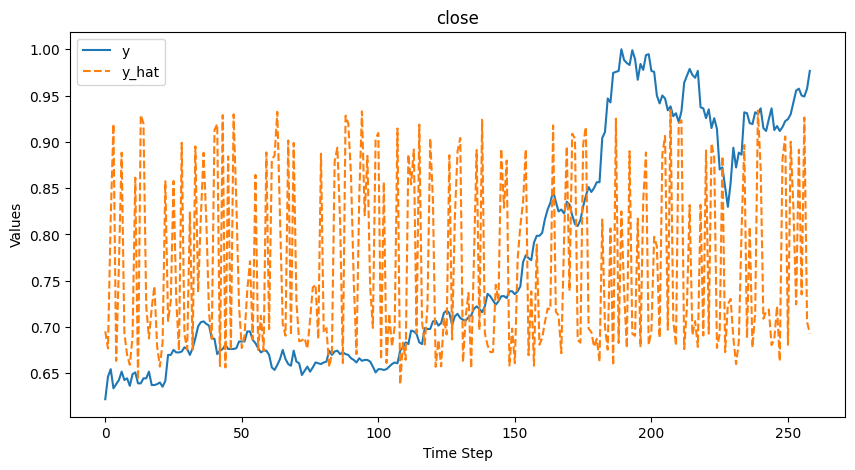

In [11]:
RNN_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=RNN_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)  # Adjust for output sequence length
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, lag * features]
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [13]:
MLP_multi2multi = MLP(input_size=multi2multi_loader.in_variable*input_size,
                      hidden_size=hidden_size,
                      output_size=multi2multi_loader.out_variable,
                      ahead=label_size)
MLP_multi2multi_manager = ModelManager(model=MLP_multi2multi,
                                       train_loader=multi2multi_loader.train_loader,
                                       val_loader=multi2multi_loader.val_loader,
                                       lr=learning_rate,
                                       patience=patience)
MLP_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights/multi2multi/best-MLP.pth
Epoch [1/1000], time: 0s, loss: 0.0365, val_loss: 0.0830
Model saved to weights/multi2multi/best-MLP.pth
Epoch [2/1000], time: 0s, loss: 0.0153, val_loss: 0.0825
Model saved to weights/multi2multi/best-MLP.pth
Epoch [3/1000], time: 0s, loss: 0.0185, val_loss: 0.0219
Epoch [4/1000], time: 0s, loss: 0.0084, val_loss: 0.0419
Epoch [5/1000], time: 0s, loss: 0.0093, val_loss: 0.0449
Epoch [6/1000], time: 0s, loss: 0.0072, val_loss: 0.0267
Epoch [7/1000], time: 0s, loss: 0.0076, val_loss: 0.0572
Epoch [8/1000], time: 0s, loss: 0.0084, val_loss: 0.0252
Model saved to weights/multi2multi/best-MLP.pth
Epoch [9/1000], time: 0s, loss: 0.0060, val_loss: 0.0209
Epoch [10/1000], time: 0s, loss: 0.0065, val_loss: 0.0760
Epoch [11/1000], time: 0s, loss: 0.0154, val_loss: 0.0244
Epoch [12/1000], time: 0s, loss: 0.0060, val_loss: 0.0234
Epoch [13/1000], time: 0s, loss: 0.0059, val_loss: 0.0414
Model saved to weights/multi2multi/best-MLP.pth
Epoch [14/1000]

{'Name': 'MLP', 'Type': 'multi2multi', 'MAE': 0.014595421589910984}

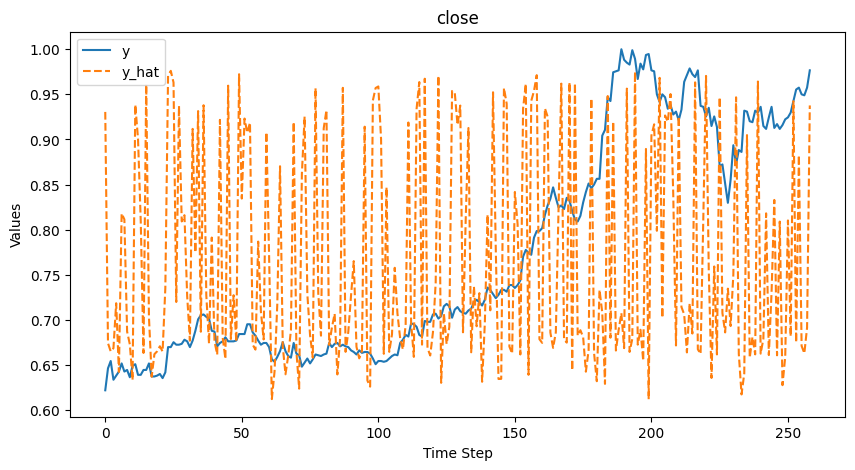

In [14]:
MLP_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=MLP_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [16]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2multi_loader.train_loader,
                                        val_loader=multi2multi_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
LSTM_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights/multi2multi/best-LSTM.pth
Epoch [1/1000], time: 2s, loss: 0.0796, val_loss: 0.0849
Model saved to weights/multi2multi/best-LSTM.pth
Epoch [2/1000], time: 3s, loss: 0.0120, val_loss: 0.0361
Model saved to weights/multi2multi/best-LSTM.pth
Epoch [3/1000], time: 1s, loss: 0.0080, val_loss: 0.0171
Epoch [4/1000], time: 1s, loss: 0.0069, val_loss: 0.0287
Epoch [5/1000], time: 1s, loss: 0.0057, val_loss: 0.0254
Epoch [6/1000], time: 1s, loss: 0.0054, val_loss: 0.0324
Epoch [7/1000], time: 1s, loss: 0.0061, val_loss: 0.0188
Epoch [8/1000], time: 1s, loss: 0.0057, val_loss: 0.0231
Model saved to weights/multi2multi/best-LSTM.pth
Epoch [9/1000], time: 1s, loss: 0.0054, val_loss: 0.0167
Epoch [10/1000], time: 1s, loss: 0.0052, val_loss: 0.0201
Epoch [11/1000], time: 1s, loss: 0.0048, val_loss: 0.0309
Epoch [12/1000], time: 1s, loss: 0.0056, val_loss: 0.0291
Model saved to weights/multi2multi/best-LSTM.pth
Epoch [13/1000], time: 1s, loss: 0.0048, val_loss: 0.0153
Epoch [14/

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 0.018742931820452214}

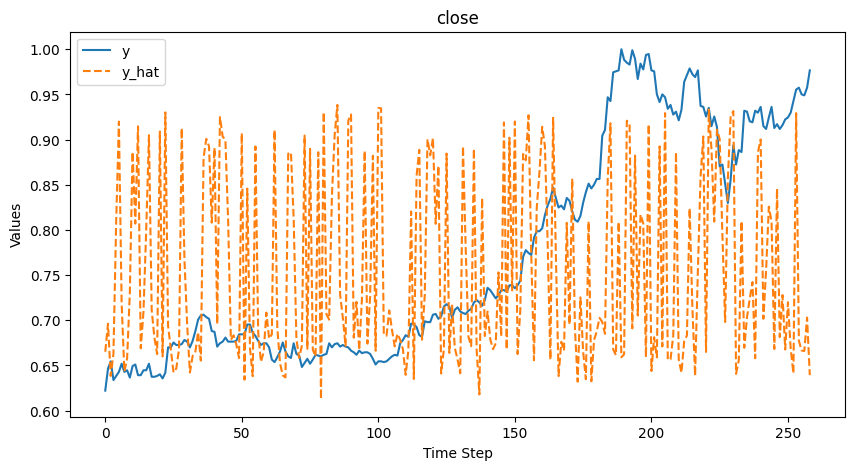

In [17]:
LSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                              yhat=LSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                              feature_names=multi2multi_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

In [18]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


In [19]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable,
                            hidden_size=hidden_size,
                            output_size=multi2multi_loader.out_variable,
                            ahead=label_size,
                            num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi,
                                          train_loader=multi2multi_loader.train_loader,
                                          val_loader=multi2multi_loader.val_loader,
                                          lr=learning_rate,
                                          patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs,
                                 save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch [1/1000], time: 3s, loss: 0.0328, val_loss: 0.0318
Epoch [2/1000], time: 2s, loss: 0.0095, val_loss: 0.0670
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch [3/1000], time: 2s, loss: 0.0059, val_loss: 0.0294
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch [4/1000], time: 2s, loss: 0.0071, val_loss: 0.0229
Epoch [5/1000], time: 2s, loss: 0.0061, val_loss: 0.0320
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch [6/1000], time: 3s, loss: 0.0052, val_loss: 0.0177
Epoch [7/1000], time: 2s, loss: 0.0050, val_loss: 0.0826
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch [8/1000], time: 2s, loss: 0.0142, val_loss: 0.0117
Epoch [9/1000], time: 2s, loss: 0.0059, val_loss: 0.0311
Epoch [10/1000], time: 2s, loss: 0.0065, val_loss: 0.0260
Epoch [11/1000], time: 2s, loss: 0.0043, val_loss: 0.0213
Epoch [12/1000], time: 3s, loss: 0.0048, val_loss: 0.0127
Epoch [13/1000], time: 2s, loss: 0.0043, val_loss: 0.0181


{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 0.024054340086877346}

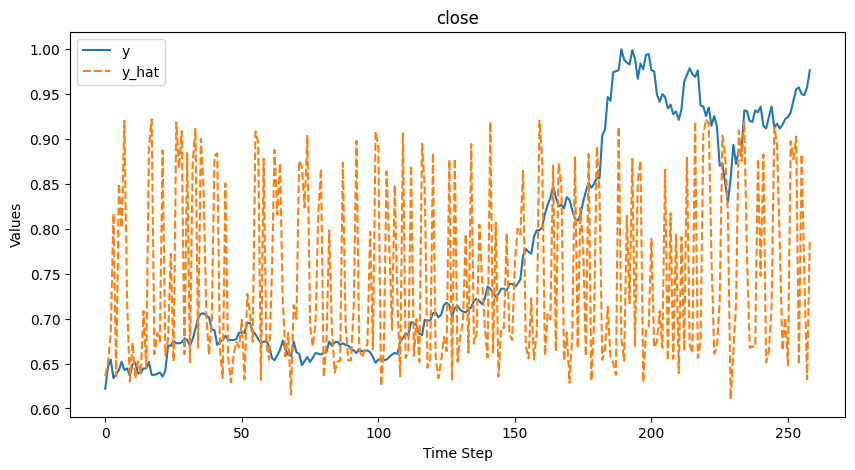

In [20]:
BiLSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                                yhat=BiLSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                                feature_names=multi2multi_loader.out_features,
                                save_dir=os.path.join(plot_dir, sub_dir),
                                save_plots=True,
                                num_elements=ele)

In [21]:
def inference(y, yhat, df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df['close'].values.reshape(-1, 1))

    y_inverse = scaler.inverse_transform(y.reshape(-1, 1))
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))

    d_inverse = pd.DataFrame({'Time': df['time'].tail(259).values,
                              'Actual': y_inverse.flatten(),
                              'Predicted': yhat_inverse.flatten()})

    return d_inverse

In [28]:
yhat=BiLSTM_multi2multi_manager.predict(multi2multi_loader.test_loader)
df = pd.read_csv("/content/drive/MyDrive/Thesis/fpt_stock.csv")
y = multi2multi_loader.y_test
inference(y, yhat, df)

,Time,Actual,Predicted
0,2022-12-06,0.622061,0.653165
1,2022-12-07,0.646421,0.666616
2,2022-12-08,0.654505,0.650692
3,2022-12-09,0.633752,0.845515
4,2022-12-12,0.638336,0.664424
...,...,...,...
254,2023-12-11,0.957451,0.877569
255,2023-12-12,0.950005,0.823222
256,2023-12-13,0.948942,0.668062
257,2023-12-14,0.957451,0.881329
